In [230]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [231]:
#df_btc = pd.read_csv("../../cryptoData/BTC_1h_data.csv")
df_xrp = pd.read_csv("XRP_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [232]:
# Removing everything but the closing price
xrp_data = df_xrp.values[:, 4 ,].astype(float)

xrp_data[-1]

0.8216

In [233]:
len(xrp_data)

33017

<Strong> Scaling the data  </Strong>

In [234]:
percTrain = 70
percVal = 20 

In [235]:
scaler = MinMaxScaler()
    
onePercent = len(xrp_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = xrp_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_xrp = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [236]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [237]:
# Using 24 datapoints to predict the 25th

window_length = 24
features = 1

sliding_winda_xrp = sliding_window(scaled_xrp , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [238]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [239]:
#Reshaping the data so we can use min-max a
xrp_train , xrp_val , xrp_test = splitting_train_test(sliding_winda_xrp)

print(xrp_train[0].shape)

(23030, 24, 1)


<Strong> create the model. </Strong>

In [240]:
inputs = Input(shape = (window_length , features) )

x = LSTM(30, return_sequences = True)(inputs)
x = Dropout(0.05)(x)
x = LSTM(50)(x)
x = Dense(units = 64 ,activation='relu')(x)
x = Dense(units = 1)(x) 

model = tf.keras.Model(inputs=inputs, outputs= x)
model.summary()
plot_model(model)

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt , loss = 'mse')

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 lstm_28 (LSTM)              (None, 24, 30)            3840      
                                                                 
 dropout_13 (Dropout)        (None, 24, 30)            0         
                                                                 
 lstm_29 (LSTM)              (None, 50)                16200     
                                                                 
 dense_28 (Dense)            (None, 64)                3264      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 23,369
Trainable params: 23,369
Non-trainabl

<Strong> Creating a callback to avail of early stopping </Strong>

In [241]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

<Strong> Training the model and storing the epoch training stopped on </Strong>

In [242]:
#Validation set needs to be in a tuple with x , y

history = model.fit(xrp_train[0] , xrp_train[1] , validation_data = xrp_val  , batch_size = 512  , epochs =500 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch



Epoch 1/500
45/45 [==============================] - 4s 23ms/step - loss: 0.0115 - val_loss: 0.0143
Epoch 2/500
45/45 [==============================] - 0s 7ms/step - loss: 2.3759e-04 - val_loss: 0.0277
Epoch 3/500
45/45 [==============================] - 0s 7ms/step - loss: 1.8499e-04 - val_loss: 0.0260
Epoch 4/500
45/45 [==============================] - 0s 7ms/step - loss: 1.8063e-04 - val_loss: 0.0256
Epoch 5/500
45/45 [==============================] - 0s 7ms/step - loss: 1.7768e-04 - val_loss: 0.0233
Epoch 6/500
45/45 [==============================] - 0s 7ms/step - loss: 1.7557e-04 - val_loss: 0.0231
Epoch 7/500
45/45 [==============================] - 0s 7ms/step - loss: 1.6782e-04 - val_loss: 0.0199
Epoch 8/500
45/45 [==============================] - 0s 7ms/step - loss: 1.6773e-04 - val_loss: 0.0204
Epoch 9/500
45/45 [==============================] - 0s 7ms/step - loss: 1.6195e-04 - val_loss: 0.0179
Epoch 10/500
45/45 [==============================] - 0s 7ms/step - loss: 1.

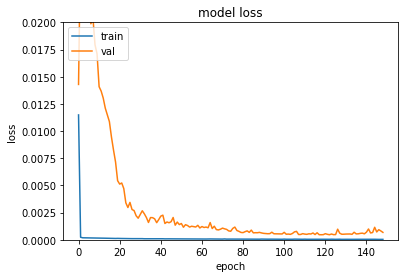

In [243]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.02])
plt.show()

<Strong> Testing our model on the validation data once again , hyper-parameter adjustment. <Strong>

In [244]:
validation_predict = model.predict(eth_val[0])
validation_predict = scaler.inverse_transform(validation_predict)

validation_actual = scaler.inverse_transform(eth_val[1])
mean_absolute_error(validation_actual , validation_predict)

0.03318034789095613

<Strong> Combining the train and validation set when perfected hyper-parameters and training on fresh model. </Strong>

In [245]:
train_and_val = np.concatenate([eth_train[0] , eth_val[0]] )
train_and_val_targets = np.concatenate([eth_train[1] , eth_val[1] ])

freshModel = tf.keras.Model(inputs=inputs, outputs= x)

freshModel.compile(optimizer='adam' , loss = 'mse')
final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs )

Epoch 1/148
69/69 [==============================] - 3s 7ms/step - loss: 7.1433e-04
Epoch 2/148
69/69 [==============================] - 0s 5ms/step - loss: 2.7368e-04
Epoch 3/148
69/69 [==============================] - 0s 5ms/step - loss: 2.3545e-04
Epoch 4/148
69/69 [==============================] - 0s 5ms/step - loss: 2.1483e-04
Epoch 5/148
69/69 [==============================] - 0s 6ms/step - loss: 2.0654e-04
Epoch 6/148
69/69 [==============================] - 0s 6ms/step - loss: 1.7975e-04
Epoch 7/148
69/69 [==============================] - 0s 6ms/step - loss: 1.9449e-04
Epoch 8/148
69/69 [==============================] - 0s 6ms/step - loss: 1.7719e-04
Epoch 9/148
69/69 [==============================] - 0s 5ms/step - loss: 1.8784e-04
Epoch 10/148
69/69 [==============================] - 0s 5ms/step - loss: 1.9803e-04
Epoch 11/148
69/69 [==============================] - 0s 5ms/step - loss: 1.9986e-04
Epoch 12/148
69/69 [==============================] - 0s 5ms/step - loss: 

<Strong> Finally testing on test set and grabbing evaluation metrics - 1 day </Strong>

In [246]:
test_predict = freshModel.predict(xrp_test[0])
test_actual = xrp_test[1]

In [247]:
print(mean_absolute_error(test_actual , test_predict))
print(mean_absolute_percentage_error(test_actual , test_predict))
print(mean_squared_error(test_actual , test_predict , squared = False))
print(mean_squared_error(test_actual , test_predict))

0.007813678664971681
0.008081451215370905
0.01137312817105585
0.00012934804439526418


<Strong> For Predicting more than 1 day in the future - Test Set. </Strong>

In [248]:
def steps_in_future(hours_in_future , data):
    
    #All the hours_in_future time predictions
    predictions = []
    
    # Have to cut off the (hours_in_future - 1) off the test set to avoid out of bounds error
    test_data = data[0][:-(hours_in_future - 1)]
    
    for x in range (len(test_data)):
        #Going through all the windows
        last_window = test_data[x].reshape(1,-1)
    
            # Make as many predictions as hours_in_future
        for i in range(hours_in_future):
            
            # Take the predicted value from the last window in training set
            last_prediction = model.predict(last_window)[0]

            #shifting the window size one step down
            last_window[0] = np.roll(last_window[0], -1)

            #replacing the old value with new prediction
            last_window[0 , (len(last_window[0]) - 1)] = last_prediction

        #append prediction
        predictions.append(last_prediction)
    
    return predictions

In [249]:
three_day_predictions = steps_in_future(3, xrp_test)
five_day_predictions = steps_in_future(5, xrp_test)
seven_day_predictions = steps_in_future( 7, xrp_test)
nine_day_predictions = steps_in_future( 9, xrp_test)
eleven_day_predictions = steps_in_future( 11, xrp_test)

In [250]:
# Targets to compare  

targets_in_future_three = xrp_test[1][(3 - 1):]
targets_in_future_five = xrp_test[1][(5 - 1):]
targets_in_future_seven = xrp_test[1][(7 - 1):]
targets_in_future_nine = xrp_test[1][(9 - 1):]
targets_in_future_eleven = xrp_test[1][(11 - 1):]

In [251]:
def get_eval_metrics(num_days , actual , results):
    
    mae = mean_absolute_error(actual , results)
    mse = mean_squared_error(actual , results )
    rmse = mean_squared_error(actual , results , squared = False)
    mape = mean_absolute_percentage_error(actual , results)

    print(num_days , "MAE :" , mae ,"MSE :" , mse , "RMSE :" , rmse , "MAPE :" , mape)

    return mae , mse , rmse , mape

In [252]:
three_days_mae , three_days_mse , three_days_rmse , three_days_mape = get_eval_metrics("Three Hour Forecast" , targets_in_future_three , three_day_predictions)
five_days_mae , five_days_mse , five_days_rmse , five_days_mape = get_eval_metrics("Five Hour Forecast" , targets_in_future_five , five_day_predictions)
seven_days_mae , seven_days_mse , seven_days_rmse , seven_days_mape = get_eval_metrics("Seven Hour Forecast" , targets_in_future_seven , seven_day_predictions)
nine_days_mae , nine_days_mse , nine_days_rmse , nine_days_mape = get_eval_metrics("Nine Hour Forecast" , targets_in_future_nine , nine_day_predictions)
eleven_days_mae , eleven_days_mse , eleven_days_rmse , eleven_days_mape = get_eval_metrics("Eleven Hour Forecast" , targets_in_future_eleven , eleven_day_predictions)




Three Hour Forecast MAE : 0.015079399265392313 MSE : 0.000434381052448295 RMSE : 0.020841810200850956 MAPE : 0.015905107998967945
Five Hour Forecast MAE : 0.026097235767230567 MSE : 0.0010758355643167114 RMSE : 0.032799932382807005 MAPE : 0.028375448598149035
Seven Hour Forecast MAE : 0.04034575851105517 MSE : 0.0023370811419944327 RMSE : 0.048343367094095056 MAPE : 0.0447967721422602
Nine Hour Forecast MAE : 0.05783236834919574 MSE : 0.004600649619664693 RMSE : 0.06782808872189082 MAPE : 0.06553985285508362
Eleven Hour Forecast MAE : 0.07925021456249269 MSE : 0.008432318591587648 RMSE : 0.09182765700804768 MAPE : 0.09127703906570565
